# **P-tuning**

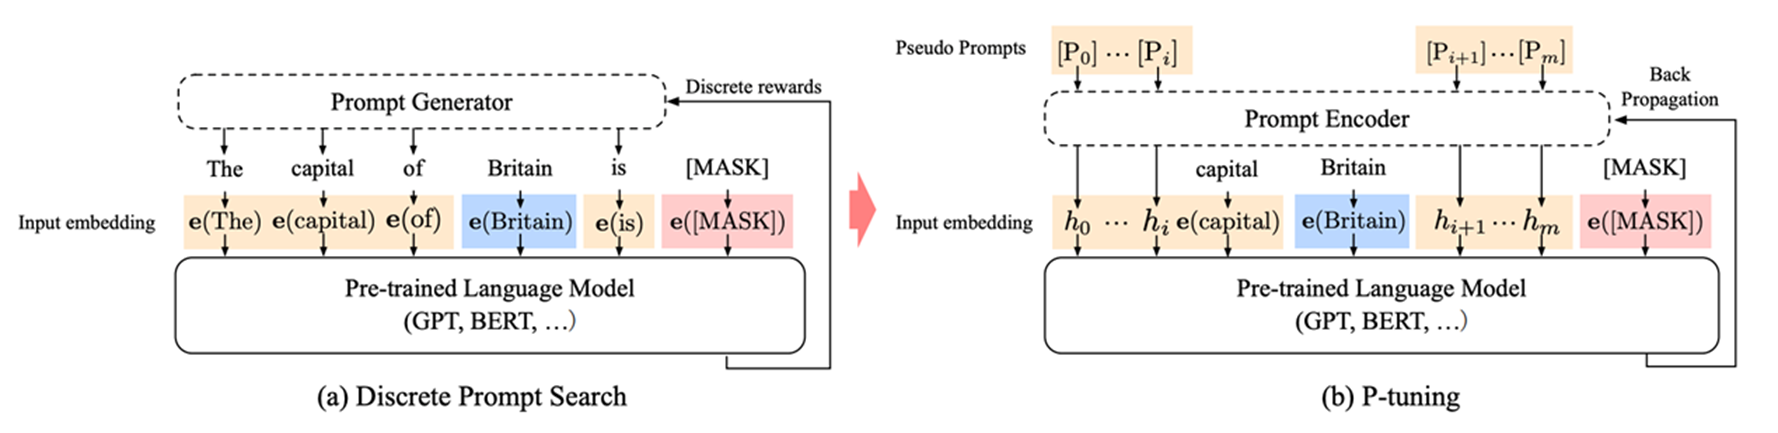

P-Tuning is a method developed to optimize the performance of language models in natural language understanding (NLU) tasks, aiming to overcome the limitations of traditional discrete prompts. Based on the soft prompt concept, the method uses a trainable embedding tensor optimized through a specialized prompt encoder — typically a bidirectional LSTM network. This approach allows for more refined model adaptation to specific tasks while maintaining computational efficiency.

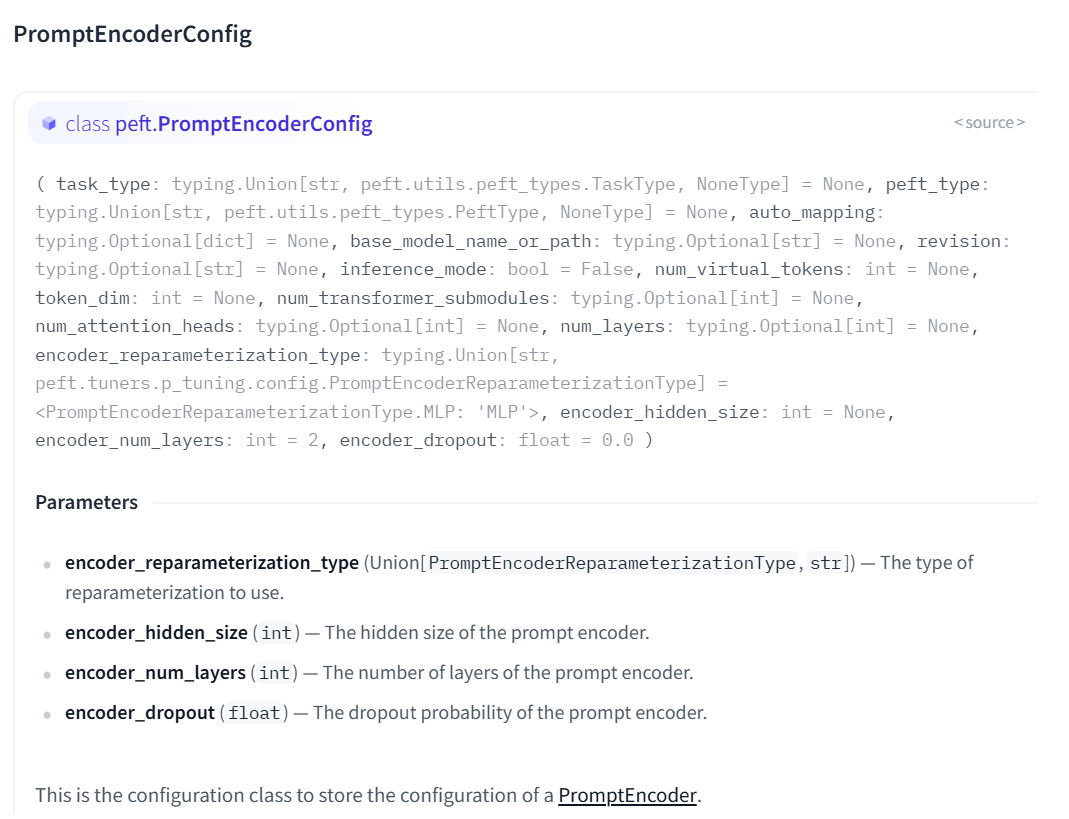

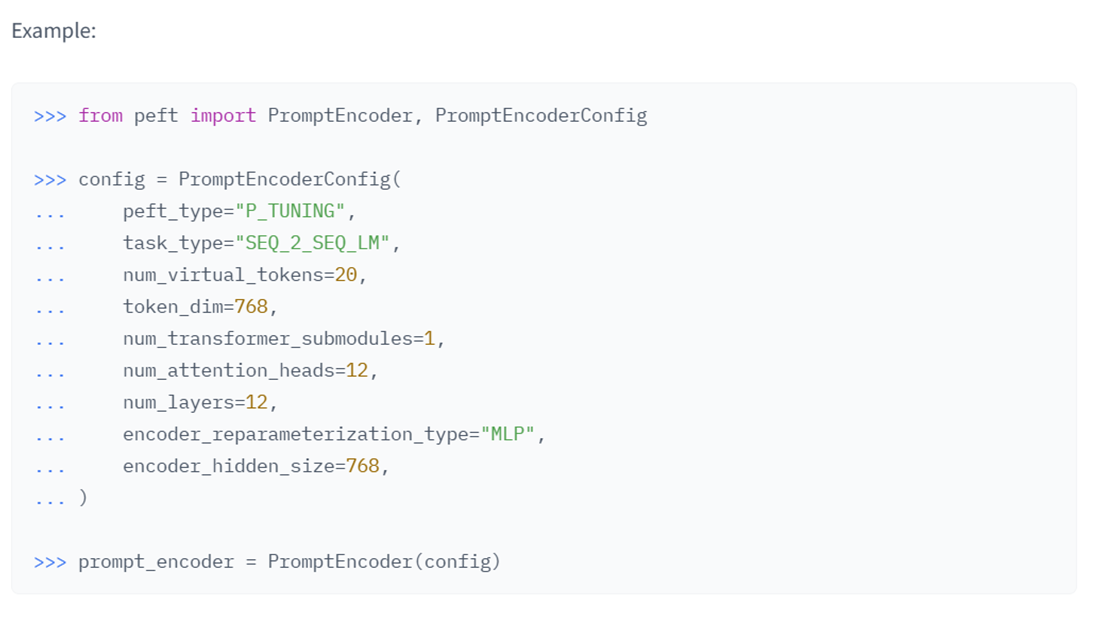

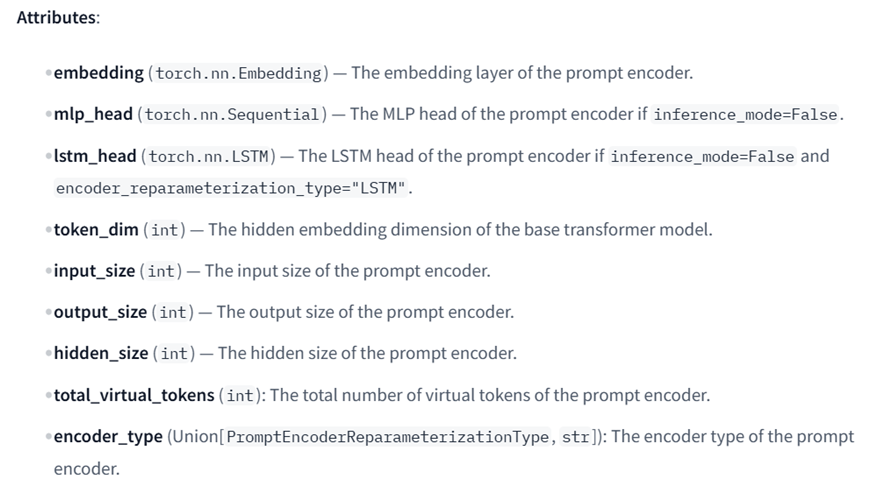

# Overview

We can use `prompts` to steer the model toward a particular downstream task without fully finetuning a model. Typically, these prompts are handcrafted, which may be impractical because we need very large validation sets to find the best prompts.

**P-tuning** is a method for automatically searching and optimizing for better prompts in a continuous space. Here is the paper [GPT Understands Too](https://arxiv.org/abs/2103.10385).

We will train a roberta-large model(the any of the GPT, OPT, or BLOOM models will be fine) with p-tuning on the mrpc configuration of the [GLUE](https://huggingface.co/datasets/glue) benchmark.

## **First Example:**

### Train a `roberta-large` model (but you can also use any of the GPT, OPT, or BLOOM models) with `p-tuning` on the mrpc configuration of the [GLUE benchmark](https://huggingface.co/datasets/nyu-mll/glue).

#### **mrpc**

The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for **whether the sentences in the pair are semantically equivalent.**

In [ ]:
!pip install transformers==4.36.2
!pip install peft==0.7.1
!pip install datasets==2.15.0
!pip install evaluate==0.4.1
!pip install tqdm==4.66.1
!pip install wandb==0.16.2

  Obtaining dependency information for peft==0.7.1 from https://files.pythonhosted.org/packages/8b/1b/aee2a330d050c493642d59ba6af51f3910cb138ea48ede228c84c204a5af/peft-0.7.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 8.0 MB/s eta 0:00:00
  Obtaining dependency information for datasets==2.15.0 from https://files.pythonhosted.org/packages/e2/cf/db41e572d7ed958e8679018f8190438ef700aeb501b62da9e1eed9e4d69a/datasets-2.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec[http]<=2023.10.0,>=2023.1.0 from https://files.pythonhosted.org/packages/e8/f6/3eccfb530aac90ad1301c582da228e4763f19e719ac8200752a4841b0b2d/fsspec-2023.10.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 19.5 MB/s e

In [ ]:
import os
from huggingface_hub import login  ## import Hugging Face login function for authentication
from kaggle_secrets import UserSecretsClient  # import client to securely access Kaggle secrets

user_secrets = UserSecretsClient()  ## create an instance to access Kaggle stored secrets

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))  # login to Hugging Face using token stored in Kaggle secrets

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")  ## set Weights & Biases API key as environment variable
os.environ["WANDB_PROJECT"] = "Fine-tune-models"  ## set W&B project name environment variable
os.environ["WANDB_NOTES"] = "Fine tune model distilbert base uncased"  ## set W&B notes describing the run
os.environ["WANDB_NAME"] = "p-tuning-roberta-large-with-mrpc"  ## set W&B run name environment variable


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Load dataset

We will load the data from the subset of the mrpc dataset. And we want to evalute the model accuracy, so we also load a metric from the evaluate. Moreover, we will use metric from the evaluate to write a function that computes the accuracy and F1 scores.

In [ ]:
from datasets import load_dataset

dataset_name="mrpc"

dataset=load_dataset("glue", dataset_name)  # load the MRPC dataset from GLUE benchmark
dataset["train"][0]  ## preview the first example in the training set

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

In [ ]:
import evaluate
metric=evaluate.load("glue", dataset_name)  ## load GLUE evaluation metric for MRPC

In [ ]:
import numpy as np

# define a function to compute evaluation metrics during training
def compute_metrics(eval_pred):
    predictions, labels=eval_pred
    predictions=np.argmax(predictions, axis=1)  # convert model logits to predicted class indices
    return metric.compute(predictions=predictions, references=labels)  # # return computed metric scores

## Preprocess dataset

Here are common steps:
1. Initialize the tokenizer, configure the padding token to use.(GPT, OPT or BLOOM model, we should set the `padding_side` to the left); otherwise it'll be set to the right.
2. Tokenize the sentence pairs and truncate them to the maximum length.

In [ ]:
from transformers import AutoTokenizer

model_name="roberta-large"

# check if model is GPT, OPT or BLOOM for left padding
if any(k in model_name for k in ("gpt","opt","bloom")):
    padding_side="left"  # set tokenizer padding side to left for autoregressive models
else:
    padding_side="right"  ## else, set padding side to right (default for encoder models)


## load tokenizer with specified padding side
tokenizer=AutoTokenizer.from_pretrained(model_name, padding_side=padding_side)

# if tokenizer has no pad token ID defined
if getattr(tokenizer,"pad_token_id") is None:
    tokenizer.pad_token_id=tokenizer.eos_token_id  ## set pad token ID to end-of-sequence token ID (fallback)


## define function to tokenize dataset examples
def tokenize_function(examples):
    outputs=tokenizer(
        examples["sentence1"], # tokenize sentence1 field
        examples["sentence2"],
        truncation=True,
        max_length=None
    )
    return outputs

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Let's apply it to the entire dataset.

In [ ]:
## tokenize entire dataset using map function
tokenized_datasets=dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["idx", "sentence1","sentence2"],  ## remove original text columns after tokenization
)

tokenized_datasets=tokenized_datasets.rename_column("label", "labels") ## rename label column to labels as expected by transformers

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Create a collator function with DataCollatorWithPadding to pad the examples in the batches to the longest sequence in the batch:

In [ ]:
from transformers import DataCollatorWithPadding  ## import collator to dynamically pad batches

data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")  ## data collator with longest padding strategy
data_collator

DataCollatorWithPadding(tokenizer=RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}, padding='longest', max_length=None, pad_to_multiple_of=None, return

# Training

P-tuning uses a prompt encoder to optimize the prompt parameters, so we will need to initialize the PromptEncoderConfig with several arguments:
* **task_type** the type of task we are training on, in this case it is sequence classification or SEQ_CLS
* **num_virtual_tokens** the number of virtual tokens to use, or in other words, the prompt
* **encoder_hidden_size** the hidden size of the encoder used to optimize the prompt parameters

In [ ]:
from peft import PromptEncoderConfig

peft_config=PromptEncoderConfig(
    task_type="SEQ_CLS",
    num_virtual_tokens=20,
    encoder_hidden_size=128
)
peft_config

PromptEncoderConfig(peft_type=<PeftType.P_TUNING: 'P_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, num_virtual_tokens=20, token_dim=None, num_transformer_submodules=None, num_attention_heads=None, num_layers=None, encoder_reparameterization_type=<PromptEncoderReparameterizationType.MLP: 'MLP'>, encoder_hidden_size=128, encoder_num_layers=2, encoder_dropout=0.0)

In [ ]:
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model

base_model=AutoModelForSequenceClassification.from_pretrained(model_name)
model=get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,351,938 || all params: 356,713,732 || trainable%: 0.3789980252288129


# Training

We are going to set up the TrainingArguments class which is included the training hyperparameters, how to evaluate the model.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,  # weight decay for regularization
    evaluation_strategy="epoch",  ## run evaluation every epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb",  ## report metrics and logs to Weights & Biases
    run_name=os.getenv("WANDB_NAME")  ## W&B run name from environment variable
)

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240111_054255-xy7pcjvt
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run p-tuning-roberta-large-with-mrpc
wandb: ⭐️ View project at https://wandb.ai/causal_language_trainer/Fine-tune-models
wandb: 🚀 View run at https://wandb.ai/causal_language_trainer/Fine-tune-models/runs/xy7pcjvt
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.619869,0.675362,0.800285
2,No log,0.608243,0.693913,0.806593
3,No log,0.621663,0.672464,0.801266
4,No log,0.631656,0.666667,0.799302
5,No log,0.640180,0.649855,0.770342
6,No log,0.621943,0.667826,0.799440
7,No log,0.628737,0.668406,0.755556
8,No log,0.591397,0.699130,0.805107
9,0.634700,0.582560,0.687536,0.802202
10,0.634700,0.612869,0.687536,0.776441


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=1160, training_loss=0.5967186500286233, metrics={'train_runtime': 2201.4178, 'train_samples_per_second': 33.324, 'train_steps_per_second': 0.527, 'total_flos': 1.1275599307129344e+16, 'train_loss': 0.5967186500286233, 'epoch': 20.0})

# Save(share) model

In [ ]:
# push all the things which are included tokenizer*, training_args.bin, vocab.json, merges.txt and special_tokens_map.json
## push trained model and artifacts to Hugging Face Hub with repo name from env var
trainer.push_to_hub(os.getenv("WANDB_NAME"))

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.35k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.29M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aisuko/p-tuning-roberta-large-with-mrpc/commit/c2c20557af77f35ce0e4ca549e84d2537aef4b9f', commit_message='p-tuning-roberta-large-with-mrpc', commit_description='', oid='c2c20557af77f35ce0e4ca549e84d2537aef4b9f', pr_url=None, pr_revision=None, pr_num=None)

If you do not want to share the file like vocabulary, only pushing the model and adapter_config.json by using command below.

In [ ]:
# trainer.model.push_to_hub(os.getenv("WANDB_NAME"))

# Inference

In [ ]:
import torch

del model, base_model, tokenizer  ## delete model and tokenizer objects to free up memory
torch.cuda.empty_cache()  ## clear PyTorch CUDA cache to release GPU memory

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

peft_model_id="aisuko/"+os.getenv("WANDB_NAME")  ## define PEFT model repo id based on env var
config=PeftConfig.from_pretrained(peft_model_id)  ## load PEFT config from hub
base_model=AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)
tokenizer=AutoTokenizer.from_pretrained(peft_model_id)
model=PeftModel.from_pretrained(base_model, peft_model_id)  ## load PEFT model weights on base model

adapter_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.29M [00:00<?, ?B/s]

In [ ]:
classes = ["not equivalent", "equivalent"]

sentence1 = "Coast redwood trees are the tallest trees on the planet and can grow over 300 feet tall."
sentence2 = "The coast redwood trees, which can attain a height of over 300 feet, are the tallest trees on earth."

inputs = tokenizer(
    sentence1,
    sentence2,
    truncation=True,
    padding="longest",
    return_tensors="pt"
)

In [ ]:
## disable gradient calculation (inference mode)
with torch.no_grad():
    outputs=model(**inputs).logits  # # run model and get logits output
    print(outputs)

tensor([[-0.3859,  0.4505]])


In [ ]:
paraphrased_text=torch.softmax(outputs, dim=1).tolist()[0]  ## apply softmax to logits to get class probabilities
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrased_text[i]*100))}%")  # print class name and predicted probability as percentage

not equivalent: 30%
equivalent: 70%
